In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
import re
import os
import sys

from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, GlobalMaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [0]:
def preprocess_data(data):

    # replace unnecessary characters with space
    s = re.sub(r"\\n", " ", str(data).lower())
    s = re.sub(r":", "", s) 
    s = re.sub(r"\.", " ", s)
    s = re.sub(r"\,", " ", s)
    s = re.sub(r"\!", " ", s)
    s = re.sub(r"\;", " ", s)
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"[^A-Za-z0-9^+-=]", " ", s)    

    # tokenize the lower cased string 
    s = s.split()  
    
    # standard stop words list
    stop_words = list(stopwords.words('english'))    

    # Remove stop_words
    s = [w for w in s if not w in stop_words] 

    # convert tokens back to document
    s = " ".join(s).rstrip()  

    return str(s)

def read_data_into_dataframe(dir_path, filename):
    
    doc_list = []
  
    with open(os.path.join(dir_path, filename), 'r', encoding='utf-8') as f:
        doc_list = f.read().split('\n\n')        
        
    return pd.DataFrame(data=np.array(doc_list).reshape(-1, 1), columns=['doc'])

def create_final_dataset():
    # textfile path
    dir_path = 'data/'

    df_corpus_1, corpus_label_1 = read_data_into_dataframe(dir_path, "28054-0.txt"), "Fyodor Dostoyevsky"
    df_corpus_2, corpus_label_2 = read_data_into_dataframe(dir_path, "pg1661.txt"), "Arthur Conan Doyle"
    df_corpus_3, corpus_label_3 = read_data_into_dataframe(dir_path, "pg31100.txt"), "Jane Austen"

    df_corpus_1['label'] = corpus_label_1
    df_corpus_2['label'] = corpus_label_2
    df_corpus_3['label'] = corpus_label_3

    df_corpus_1 = df_corpus_1.iloc[29:6083]
    df_corpus_2 = df_corpus_2.iloc[21:2567]
    df_corpus_3 = df_corpus_3.iloc[40:11533]
    
    corpus_1_len = df_corpus_1.shape[0]
    corpus_2_len = df_corpus_2.shape[0]
    corpus_3_len = df_corpus_3.shape[0]
    
    # Balance all 3 classes
    print(df_corpus_1.sample(frac=corpus_2_len/corpus_1_len).shape,
                         df_corpus_2.shape,
                         df_corpus_3.sample(frac=corpus_2_len/corpus_3_len).shape)
    
    # combining all corpus into dataframe of documents
    df_docs = pd.concat([df_corpus_1.sample(frac=corpus_2_len/corpus_1_len),
                         df_corpus_2,
                         df_corpus_3.sample(frac=corpus_2_len/corpus_3_len)])

    # to make sure all docs are of string type
    df_docs.doc = df_docs.doc.astype(str)
    
    df_docs.reset_index(inplace=True, drop=True)
    
    return df_docs  

def split_data(data):
    # shuffle dataset
    data = data.sample(frac=1).reset_index(drop=True)
    test_size = int(0.2*data.shape[0])
    n_len = data.shape[0]
    X_train, X_test = data.iloc[:n_len-test_size, 0], data.iloc[-test_size:, 0]
    y_train, y_test = data.iloc[:n_len-test_size, 1], data.iloc[-test_size:, 1]
    return X_train, X_test, y_train, y_test

def feature_extraction(X_train, X_test):
    tfidf = TfidfVectorizer()
    tfidf_ = tfidf.fit(X_train)    
    return tfidf_.transform(X_train), tfidf_.transform(X_test)

def plot_loss(train_loss, val_loss, title):
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [10]:
## Create dataset ##

df_docs = create_final_dataset()

(2546, 2) (2546, 2) (2546, 2)


In [0]:
## Data Cleaning and Preprocessing ##

df_docs.doc = df_docs.doc.apply(lambda x: preprocess_data(x))
df_docs.label = df_docs.label.replace({"Fyodor Dostoyevsky":0, "Arthur Conan Doyle":1, "Jane Austen":2})
df = df_docs[df_docs.doc != ""]

In [12]:
df.head()

,doc,label
0,sum spent yesterday asserted dmitri fyodorovit...,0
1,easily imagine father man could would bring ch...,0
2,mentioned already looked bloated countenance t...,0
3,ran room,0
4,know see god one apart nothing rubbish fancy,0


In [13]:
## Split data into train and test sets ##

X_train, X_test, y_train, y_test = split_data(df)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5932,) (1482,) (5932,) (1482,)


In [14]:
y_train.value_counts()

0    2001
1    1967
2    1964
Name: label, dtype: int64

In [15]:
y_train_encoded = np_utils.to_categorical(y_train)
y_test_encoded = np_utils.to_categorical(y_test)

print(y_train_encoded.shape, y_test_encoded.shape)

(5932, 3) (1482, 3)


In [16]:
all_tokens = (" ".join(X_train)).split()
unique_tokens = set(all_tokens)

print("All tokens size: ", len(all_tokens))
print("Unique tokens size: ", len(unique_tokens))

All tokens size:  154837
Unique tokens size:  15297


In [17]:
max(X_train.apply(lambda x: len(x)))

5670

In [0]:
# Hyperparameters
VOCAB_SIZE = len(unique_tokens) + 1
EMBEDDING_DIMS = 100
MAX_SEQUENCE_LENGTH = 3000
FILTERS = 128 
KERNEL_SIZE = 5 
BATCH_SIZE = 128
learning_rate = 1e-3
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [19]:
#zero padding
tokenizer = text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

train = tokenizer.texts_to_sequences(X_train)
test = tokenizer.texts_to_sequences(X_test)

train = sequence.pad_sequences(train, maxlen=MAX_SEQUENCE_LENGTH)
test = sequence.pad_sequences(test, maxlen=MAX_SEQUENCE_LENGTH)

print(train.shape)

(5932, 3000)


In [0]:
# using pretrained glove

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIMS))

embeddings_index = dict()
f = open('/content/gdrive/My Drive/Stevens/Spring 2019/ML/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

for word, index in tokenizer.word_index.items():
    if index > VOCAB_SIZE - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [28]:
embedding_layer = Embedding(VOCAB_SIZE,
                            EMBEDDING_DIMS,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model...')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(FILTERS, KERNEL_SIZE, activation='relu')(embedded_sequences)
x = GlobalMaxPooling1D()(x)
output_layer = Dense(3, activation='softmax')(x)

Training model...


In [0]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=learning_rate)

model = Model(sequence_input, output_layer)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer)

In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3000)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 3000, 100)         1529800   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2996, 128)         64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 1,594,315
Trainable params: 64,515
Non-trainable params: 1,529,800
_________________________________________________________________


In [31]:
EPOCHS = 100

history = model.fit(train, y_train_encoded, batch_size=BATCH_SIZE, epochs=EPOCHS,
                   validation_split=0.20, callbacks=[es])

Train on 4745 samples, validate on 1187 samples
Epoch 1/100
4745/4745 [==============================] - 4s 864us/sample - loss: 1.0783 - val_loss: 1.0639
Epoch 2/100
4745/4745 [==============================] - 4s 811us/sample - loss: 1.0465 - val_loss: 1.0417
Epoch 3/100
4745/4745 [==============================] - 4s 810us/sample - loss: 1.0142 - val_loss: 1.0142
Epoch 4/100
4745/4745 [==============================] - 4s 815us/sample - loss: 0.9680 - val_loss: 0.9713
Epoch 5/100
4745/4745 [==============================] - 4s 810us/sample - loss: 0.9066 - val_loss: 0.9194
Epoch 6/100
4745/4745 [==============================] - 4s 808us/sample - loss: 0.8443 - val_loss: 0.8747
Epoch 7/100
4745/4745 [==============================] - 4s 812us/sample - loss: 0.7847 - val_loss: 0.8416
Epoch 8/100
4745/4745 [==============================] - 4s 807us/sample - loss: 0.7378 - val_loss: 0.8126
Epoch 9/100
4745/4745 [==============================] - 4s 806us/sample - loss: 0.6938 - val_lo

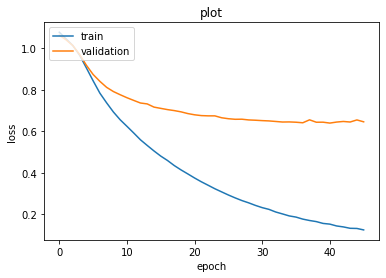

In [32]:
# plot
plot_loss(history.history['loss'], history.history['val_loss'], "plot")

In [33]:
print("Classification loss on validation set: ", history.history['val_loss'][-1])
print()
classification_loss = model.evaluate(test, y_test_encoded)
print("Classification loss on test set: ", classification_loss)

Classification loss on validation set:  0.6464307480683925

1482/1482 [==============================] - 1s 531us/sample - loss: 0.6704
Classification loss on test set:  0.6703664288829695


In [34]:
preds = model.predict(test)
preds

array([[2.7280137e-01, 5.1823342e-01, 2.0896527e-01],
       [8.0405008e-03, 8.3174400e-02, 9.0878510e-01],
       [1.4867629e-01, 6.7012526e-02, 7.8431118e-01],
       ...,
       [9.8187968e-02, 7.3745149e-01, 1.6436054e-01],
       [3.4700677e-01, 3.2723764e-01, 3.2575554e-01],
       [9.9907339e-01, 6.0670695e-04, 3.1995753e-04]], dtype=float32)

In [0]:
classes = np.argmax(preds, axis=1)

In [36]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, classes)

0.7105263157894737

In [37]:
pd.Series(classes).value_counts()

1    576
2    455
0    451
dtype: int64